In [2]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\elif.ozkol\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
df_merged_by_month = pd.read_excel('C:\\Users\\elif.ozkol\\Desktop\\LSE Project\\uk_2000_2022_wage_finbert.xlsx')

df_merged_by_month

,Reference,Country,Date,Year,Month,Title,Author,IsGov,Text,WageRate,neutral_finbert,positive_finbert,negative_finbert,polarity_score_finbert
0,r000509a_BOE,United Kingdom,2000-05-09,2000,May,The Entrepreneurial Economy: A Collaborative A...,Clementi,No,delighted opportunity address end sure thought...,NaN,0.551620,0.447168,0.001211,0.445957
1,r000503a_BOE,United Kingdom,2000-05-03,2000,May,Speech,Clark,No,delighted evening delighted also slightly emba...,NaN,0.983109,0.015571,0.001320,0.014250
2,r000531a_BOE,United Kingdom,2000-05-31,2000,May,The Exchange Rate and the MPC: What can we do?,Wadhwani,No,even recent fall current level sterling versus...,NaN,0.484306,0.514697,0.000997,0.513700
3,r000613a_BOE,United Kingdom,2000-06-13,2000,June,Financial Stability and the City: The Evolving...,George,Yes,thank chairman pleased take part conference sh...,NaN,0.729938,0.268412,0.001650,0.266761
4,r000614a_BOE,United Kingdom,2000-06-14,2000,June,The work of the Monetary Policy Committee,Plenderleith,No,want thank warmly kind invitation lunch today ...,NaN,0.486634,0.510779,0.002587,0.508192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,r220428a_BOE,United Kingdom,2022-04-28,2022,April,Macropru,Breeden,No,dimitri demekas paul tucker helpful discussion...,7.1,0.790335,0.163924,0.045742,0.118182
1167,r220426a_BOE,United Kingdom,2022-04-26,2022,April,Bufferati,Woods,No,copies publications available publication avai...,7.1,0.483925,0.515084,0.000991,0.514093
1168,r220503a_BOE,United Kingdom,2022-05-03,2022,May,Why macroprudential policy needs to tackle fin...,Stheeman,No,elisabeth stheeman notes climate change transi...,6.5,0.867319,0.018150,0.114531,-0.096382
1169,r221019a_BOE,United Kingdom,2022-10-19,2022,October,"Governance of “Decentralised” Finance: Get up,...",Wilkins,No,divided seven categories suffrage systems whos...,6.2,0.983664,0.015353,0.000983,0.014370


In [6]:
# Ensure 'Month' column is treated as categorical with proper month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

df_merged_by_month['Month'] = pd.Categorical(df_merged_by_month['Month'], categories=month_order, ordered=True)

monthly_avg = df_merged_by_month.groupby('Month', observed=True).agg({
    'WageRate': 'mean',
    'neutral_finbert': 'mean',
    'positive_finbert': 'mean',
    'negative_finbert': 'mean',
    'polarity_score_finbert': 'mean',
    'Reference': 'count'
}).reset_index()
# Rename for clarity
monthly_avg.rename(columns={'Reference': 'NumofSpeeches'}, inplace=True)

# Sort by proper month order
monthly_avg = monthly_avg.sort_values('Month')


monthly_avg

,Month,WageRate,neutral_finbert,positive_finbert,negative_finbert,polarity_score_finbert,NumofSpeeches
0,January,2.954321,0.754202,0.154526,0.091271,0.063255,87
1,February,2.642268,0.759208,0.166323,0.074468,0.091855,105
2,March,2.833884,0.818400,0.125679,0.055921,0.069758,125
3,April,3.183333,0.718374,0.193003,0.088623,0.104380,81
4,May,3.317925,0.784587,0.149554,0.065859,0.083695,110
5,June,2.941803,0.771538,0.168945,0.059517,0.109428,126
6,July,3.388298,0.813791,0.141820,0.044389,0.097432,96
7,August,2.650000,0.776232,0.134827,0.088942,0.045885,25
8,September,2.818584,0.750226,0.147087,0.102687,0.044400,115
9,October,2.732576,0.793330,0.128891,0.077779,0.051111,135


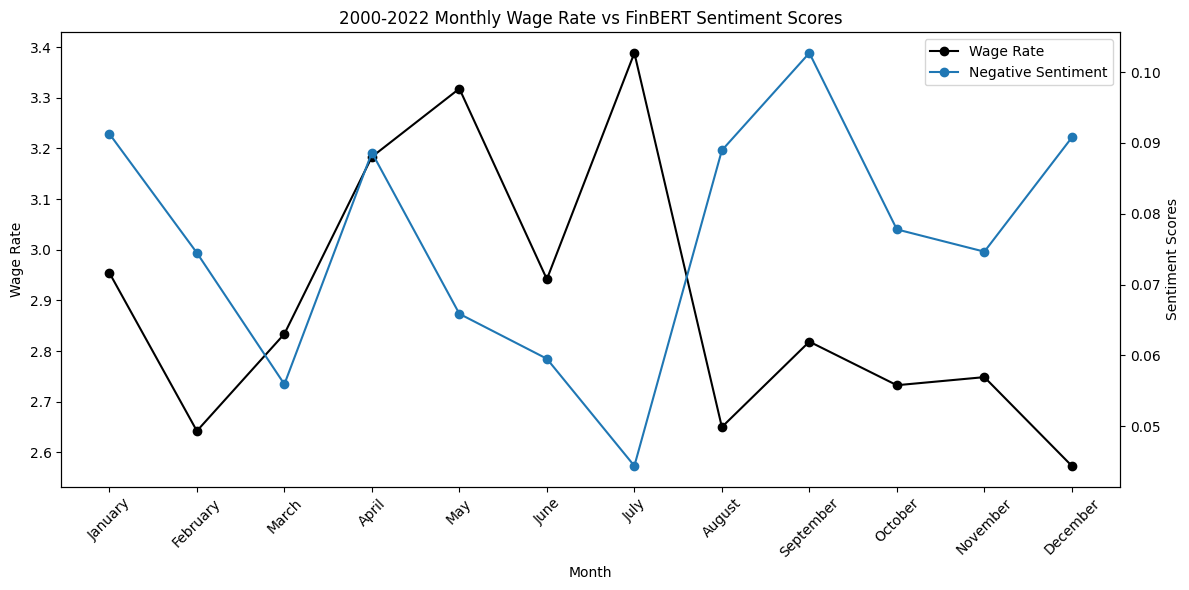

In [8]:
# Plot the updated data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Rate on primary y-axis
ax1.plot(monthly_avg['Month'], monthly_avg['WageRate'], marker='o', label='Wage Rate', color='black')
ax1.set_ylabel('Wage Rate')
ax1.set_xlabel('Month')
ax1.tick_params(axis='x', rotation=45)

# Plot sentiment metrics on secondary y-axis
ax2 = ax1.twinx()
#ax2.plot(monthly_avg['Month'], monthly_avg['positive_finbert'], marker='o', label='Positive Sentiment')
ax2.plot(monthly_avg['Month'], monthly_avg['negative_finbert'], marker='o', label='Negative Sentiment')
#ax2.plot(monthly_avg['Month'], monthly_avg['polarity_score_finbert'], marker='o', label='Polarity Score')
ax2.set_ylabel('Sentiment Scores')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('2000-2022 Monthly Wage Rate vs FinBERT Sentiment Scores')
plt.tight_layout()
plt.show()

There is a moderate positive relationship between negative sentiment in speeches and unemployment rate:

As negative sentiment increases, unemployment tends to be higher.

This visual supports the correlation value of +0.38 

The correlation between the wage rate and the calculated polarity score is:

📈 +0.623